# Cross-Assay Integrative Analyses

In [42]:
import polars as pl
import os
import seaborn as sns
import glob
%matplotlib inline

## 1. Loading allele information

### 1.1 Pillar Dataset Alleles

In [2]:
pillar_clinvar_df = pl.read_csv("../../1_allele_collection/1_inputs/raw_inputs/pillar_data/pillar_data_clinvar38_051325_wREVEL.csv", 
                                schema_overrides={"Chrom": pl.String, 'aa_pos': pl.String, 'auth_reported_score': pl.String})
print("Original pillar dataset shape:", pillar_clinvar_df.shape)

## filter the SNP variants only
pillar_clinvar_single_aa_df = pillar_clinvar_df.filter(
    (pl.col("consequence").str.contains("sense")) & \
    (pl.col("ref_allele").str.len_chars()==1) & (pl.col("alt_allele").str.len_chars()==1) & \
    (pl.col("hg38_start").is_not_null()) & (pl.col("hg38_end").is_not_null())
).drop_nulls(subset="hgvs_p").with_columns(
    pl.col("hg38_start").cast(pl.Int32).cast(pl.String).alias("nuc_loc")
)

print("Filtered missense/SNP pillar dataset shape:", pillar_clinvar_single_aa_df.shape)

pillar_clinvar_single_aa_df = pillar_clinvar_single_aa_df.with_columns(
    pl.col("hgvs_p").str.split(".").list.get(-1).alias("aa_change")
).with_columns(
    pl.concat_str([pl.col("Gene"),pl.col("aa_change")], separator="_").alias("gene_variant")
).sort("gene_variant", "gnomad_MAF", descending=[False,False])

print("Number of unique gene variants:", pillar_clinvar_single_aa_df.unique(subset="gene_variant").shape[0])
print("Number of unique genes:", pillar_clinvar_single_aa_df.unique(subset="Gene").shape[0])

# display(pillar_clinvar_single_aa_df) #.filter(pl.col("Ref_seq_transcript_ID").str.contains("NC_"))
pillar_clinvar_single_aa_df.head()

Original pillar dataset shape: (1063392, 59)
Filtered missense/SNP pillar dataset shape: (128386, 60)
Number of unique gene variants: 61155
Number of unique genes: 33


ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,Flag,REVEL,Interval 1 name,Interval 1 range,Interval 1 MaveDB class,Interval 2 name,Interval 2 range,Interval 2 MaveDB class,Interval 3 name,Interval 3 range,Interval 3 MaveDB class,Interval 4 name,Interval 4 range,Interval 4 MaveDB class,Interval 5 name,Interval 5 range,Interval 5 MaveDB class,Interval 6 name,Interval 6 range,Interval 6 MaveDB class,nuc_loc,aa_change,gene_variant
str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""-0.1191""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""","""protein toxicity""","""No""","""missense_variant""",null,0.714,"""Toxic""","""(0.6, Inf)""","""Abnormal""","""Non-toxic""","""(-Inf, 0.4)""","""Normal""",null,null,null,null,null,null,null,null,null,null,null,null,"""3483509""","""Ala148Asp""","""ASPA_Ala148Asp"""
"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""0.9495""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-1""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Fluorescence""","""protein stability""","""No""","""missense_variant""",null,0.714,"""low abundance""","""(-Inf, 0.2)""","""Abnormal""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""3483509""","""Ala148Asp""","""ASPA_Ala148Asp"""
"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""G""",null,"""443""",null,null,"""148""","""A""","""G""","""c.443C>G""","""p.Ala148Gly""","""missense_variant""","""0.1248""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""","""protein toxicity""","""No""","""missense_variant""",null,0.679,"""Toxic""","""(0.6, Inf)""","""Abnormal""","""Non-toxic""","""(-Inf, 0.4)""","""Normal""",null,null,null,null,null,null,null,null,null,null,null,null,"""3483509""","""Ala148Gly""","""ASPA_Ala148Gly"""
"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""G""",null,"""443""",null,null,"""148""","""A""","""G""","""c.443C>G""","""p.Ala148Gly""","""missense_variant""","""0.2662""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000657-a-1""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Fluorescence""","""protein stability""","""No""","""missense_variant""",null,0.679,"""low abundance""","""(-Inf, 0.2)""","""Abnormal""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""3483509""","""Ala148Gly""","""ASPA_Ala148Gly"""

### 1.2 Imaging Data

In [83]:
img_metric_df = pl.DataFrame()
for csv_file in glob.glob("../1_inputs/imaging/*"):
    if "altered_" in csv_file:
        csv_df = pl.read_csv(csv_file)
        altered_col = [col for col in csv_df.columns if col.endswith("_both_batches")][0]
        change = csv_file.split("/")[-1].split("_")[1]
        csv_df = csv_df.with_columns(
            pl.col("allele_0").str.split("_").list.get(0).alias("Gene"),
            pl.col("allele_0").alias("gene_variant")
        ).select(
            pl.col(["Gene", "gene_variant", "AUROC_Mean", altered_col])
        ).rename({"AUROC_Mean": f"AUROC_Mean_{change}"}) #"Gene", 
    else:
        metric_type = csv_file.split("/")[-1].split("_")[-2]
        csv_df = pl.read_csv(csv_file).with_columns(
            pl.col("Variant").alias("gene_variant")
        ).select(
            pl.col(["Gene", "gene_variant", "U2OS_paired_t_stat", "U2OS_paired_t_pval"]) #
        ).rename({"U2OS_paired_t_stat": f"t_stat_{metric_type}", "U2OS_paired_t_pval": f"t_pval_{metric_type}"})

    if img_metric_df.is_empty():
        img_metric_df = csv_df
    else:
        img_metric_df = img_metric_df.join(
            csv_df,
            on=["Gene","gene_variant"], #
            how="full",
            coalesce=True
        )
        
print("VarChAMP Imaging assay unique variants:", img_metric_df.unique(subset=["gene_variant"]).shape[0])

VarChAMP Imaging assay unique variants: 475


In [84]:
var_img_pillar_df = img_metric_df.unique(subset=["gene_variant"]).join(
    pillar_clinvar_single_aa_df,
    left_on="gene_variant",
    right_on="gene_variant"
)
print("VarChAMP Imaged Variants overlapped with Pillar:", var_img_pillar_df.shape[0])

VarChAMP Imaged Variants overlapped with Pillar: 351


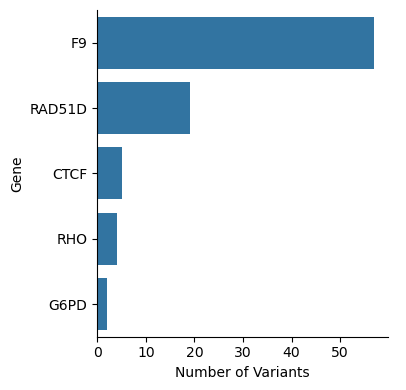

In [79]:
g = sns.catplot(data=var_img_pillar_df.unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
                x="Number of Variants", y="Gene", kind="bar", height=4, aspect=1)

### 1.3 DUAL-IPA and PPI alleles

VarChAMP DUAL-IPA assay unique variants: 816
VarChAMP DUALIPA Variants overlapped with Pillar: 31


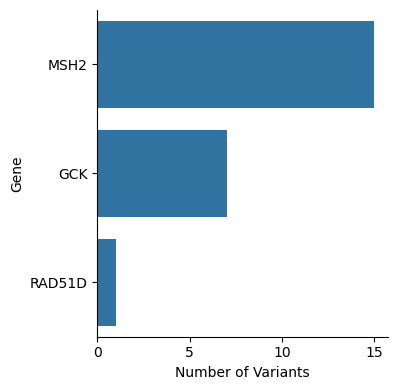

In [81]:
dual_ipa_df = pl.read_csv("../1_inputs/dual_ipa/abun_scores.csv")
print("VarChAMP DUAL-IPA assay unique variants:", dual_ipa_df.unique(subset=["allele_0"]).shape[0])

var_dualipa_pillar_df = dual_ipa_df.unique(subset=["allele_0"]).join(
    pillar_clinvar_single_aa_df,
    left_on="allele_0",
    right_on="gene_variant",
    suffix="_pillar"
)
print("VarChAMP DUALIPA Variants overlapped with Pillar:", var_dualipa_pillar_df.shape[0])
g = sns.catplot(data=var_dualipa_pillar_df.unique(subset="allele_0").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
                x="Number of Variants", y="Gene", kind="bar", height=4, aspect=1)

VarChAMP PPI assay unique variants: 836
VarChAMP PPI Variants overlapped with Pillar: 71


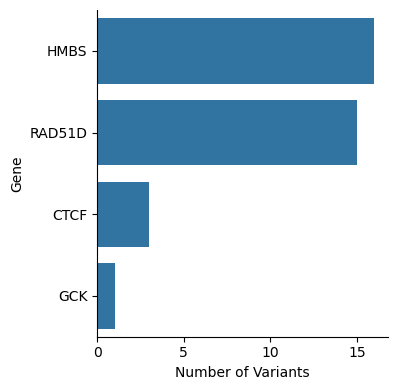

In [82]:
ppi_df = pl.read_csv("../1_inputs/ppi/edgotyping_final_combined_scores.csv")
print("VarChAMP PPI assay unique variants:", ppi_df.unique(subset=["gene_variant"]).shape[0])

ppi_pillar_df = ppi_df.unique(subset=["gene_variant"]).join(
    pillar_clinvar_single_aa_df,
    left_on="gene_variant",
    right_on="gene_variant",
    suffix="_pillar"
)

print("VarChAMP PPI Variants overlapped with Pillar:", ppi_pillar_df.shape[0])
g = sns.catplot(data=ppi_pillar_df.unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
                x="Number of Variants", y="Gene", kind="bar", height=4, aspect=1)